### feature 대상으로 LGBM 학습  
(Developed from dacon_etri_base_mod1.ipynb)

In [1]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530


submission_folder = '/users/KTL/Desktop/dacon/submission/'
submission_file = f'submission_final_mod4_1_2_{timestamp}.csv'


In [2]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch
import tensorflow as tf


In [3]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요
base_folder =  '/users/KTL/Desktop/ETRI_lifelog_dataset'
folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [4]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [5]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [6]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [7]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [8]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [9]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

In [10]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [11]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


In [12]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                if str(device['device_class']) == '0': 
                    class_0_cnt += 1 
                else: 
                    class_other_cnt += 1 
            except: 
                continue # malformed record 
        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features) 

In [13]:
def summarize_mBle_daily(df): 
    # row 단위 BLE feature 추출 
    df = process_mBle(df) 
    # 하루 단위로 cnt 합치기 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    # 총합 구해서 비율 계산 
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] 
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    # 필요 없는 원래 cnt 컬럼 제거 
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True) 
    return grouped 

mBle_df2 = summarize_mBle_daily(mBle_df) 

In [14]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [15]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

In [16]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

In [17]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0, 
        }) 
    return pd.DataFrame(features) 

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [18]:
top_apps = [ 
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
    '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
] 

def process_mUsageStats(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        app_time = {app: 0 for app in top_apps} 
        others_time = 0 
        for row in group['m_usage_stats']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for entry in parsed: 
                app = entry.get('app_name') 
                time = entry.get('total_time', 0) 
                if app in top_apps: 
                    app_time[app] += int(time) 
                else: 
                    others_time += int(time) 
        feature = { 
            'subject_id': subj, 
            'date': date, 
            'others_time': others_time 
        } 
        # 각 앱별 컬럼 추가 
        feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
        features.append(feature) 
    return pd.DataFrame(features) 

mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [19]:

def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        rssi_all = [] 
        for row in group['m_wifi']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for ap in parsed: 
                try: 
                    rssi = int(ap['rssi']) 
                    rssi_all.append(rssi) 
                except: 
                    continue 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
            'wifi_detected_cnt': len(rssi_all) 
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 

In [20]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

In [21]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [22]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

In [23]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df2, 
    mAmbience_df2, 
    mBle_df2, 
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, 
    mUsageStats_df2, 
    mWifi_df2, 
    wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


In [24]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [25]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


In [26]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 

In [27]:
# 모든 특성에 대해 모델링 진행 
X_selected = X.copy()
test_X_selected = test_X.copy()

In [28]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# # GridSearch를 위한 교차 검증 설정
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM 기본 파라미터 설정
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

In [29]:
# -------------------------------- # 
# [그리드서치 적용 X] 
# 이진 분류
binary_preds_selected = {}
binary_models_selected = {}  # 모델 객체 저장용 딕셔너리 (for Feature-Importance)


for col in targets_binary:
    print(f">> {col} 변수 진행 중..")
    y = train_df[col]
    # 이진 분류용 파라미터 조정
    binary_params = lgbm_params.copy()
    binary_params['objective'] = 'binary'
    
    model = LGBMClassifier(**binary_params)
    model.fit(X_selected, y)
    binary_preds_selected[col] = model.predict(test_X_selected)
    binary_models_selected[col] = model  # 여기에 모델 저장

# 다중 분류 (S1)
print(">> S1 변수 진행 중..")

y_multi = train_df['S1']
# 다중 분류용 파라미터 설정 (클래스 수 추가)
multiclass_params = lgbm_params.copy()
multiclass_params['num_class'] = len(y_multi.unique())

model_s1_selected = LGBMClassifier(**multiclass_params)
model_s1_selected.fit(X_selected, y_multi)  
multiclass_pred_selected = model_s1_selected.predict(test_X_selected)

>> Q1 변수 진행 중..
>> Q2 변수 진행 중..
>> Q3 변수 진행 중..
>> S2 변수 진행 중..
>> S3 변수 진행 중..
>> S1 변수 진행 중..


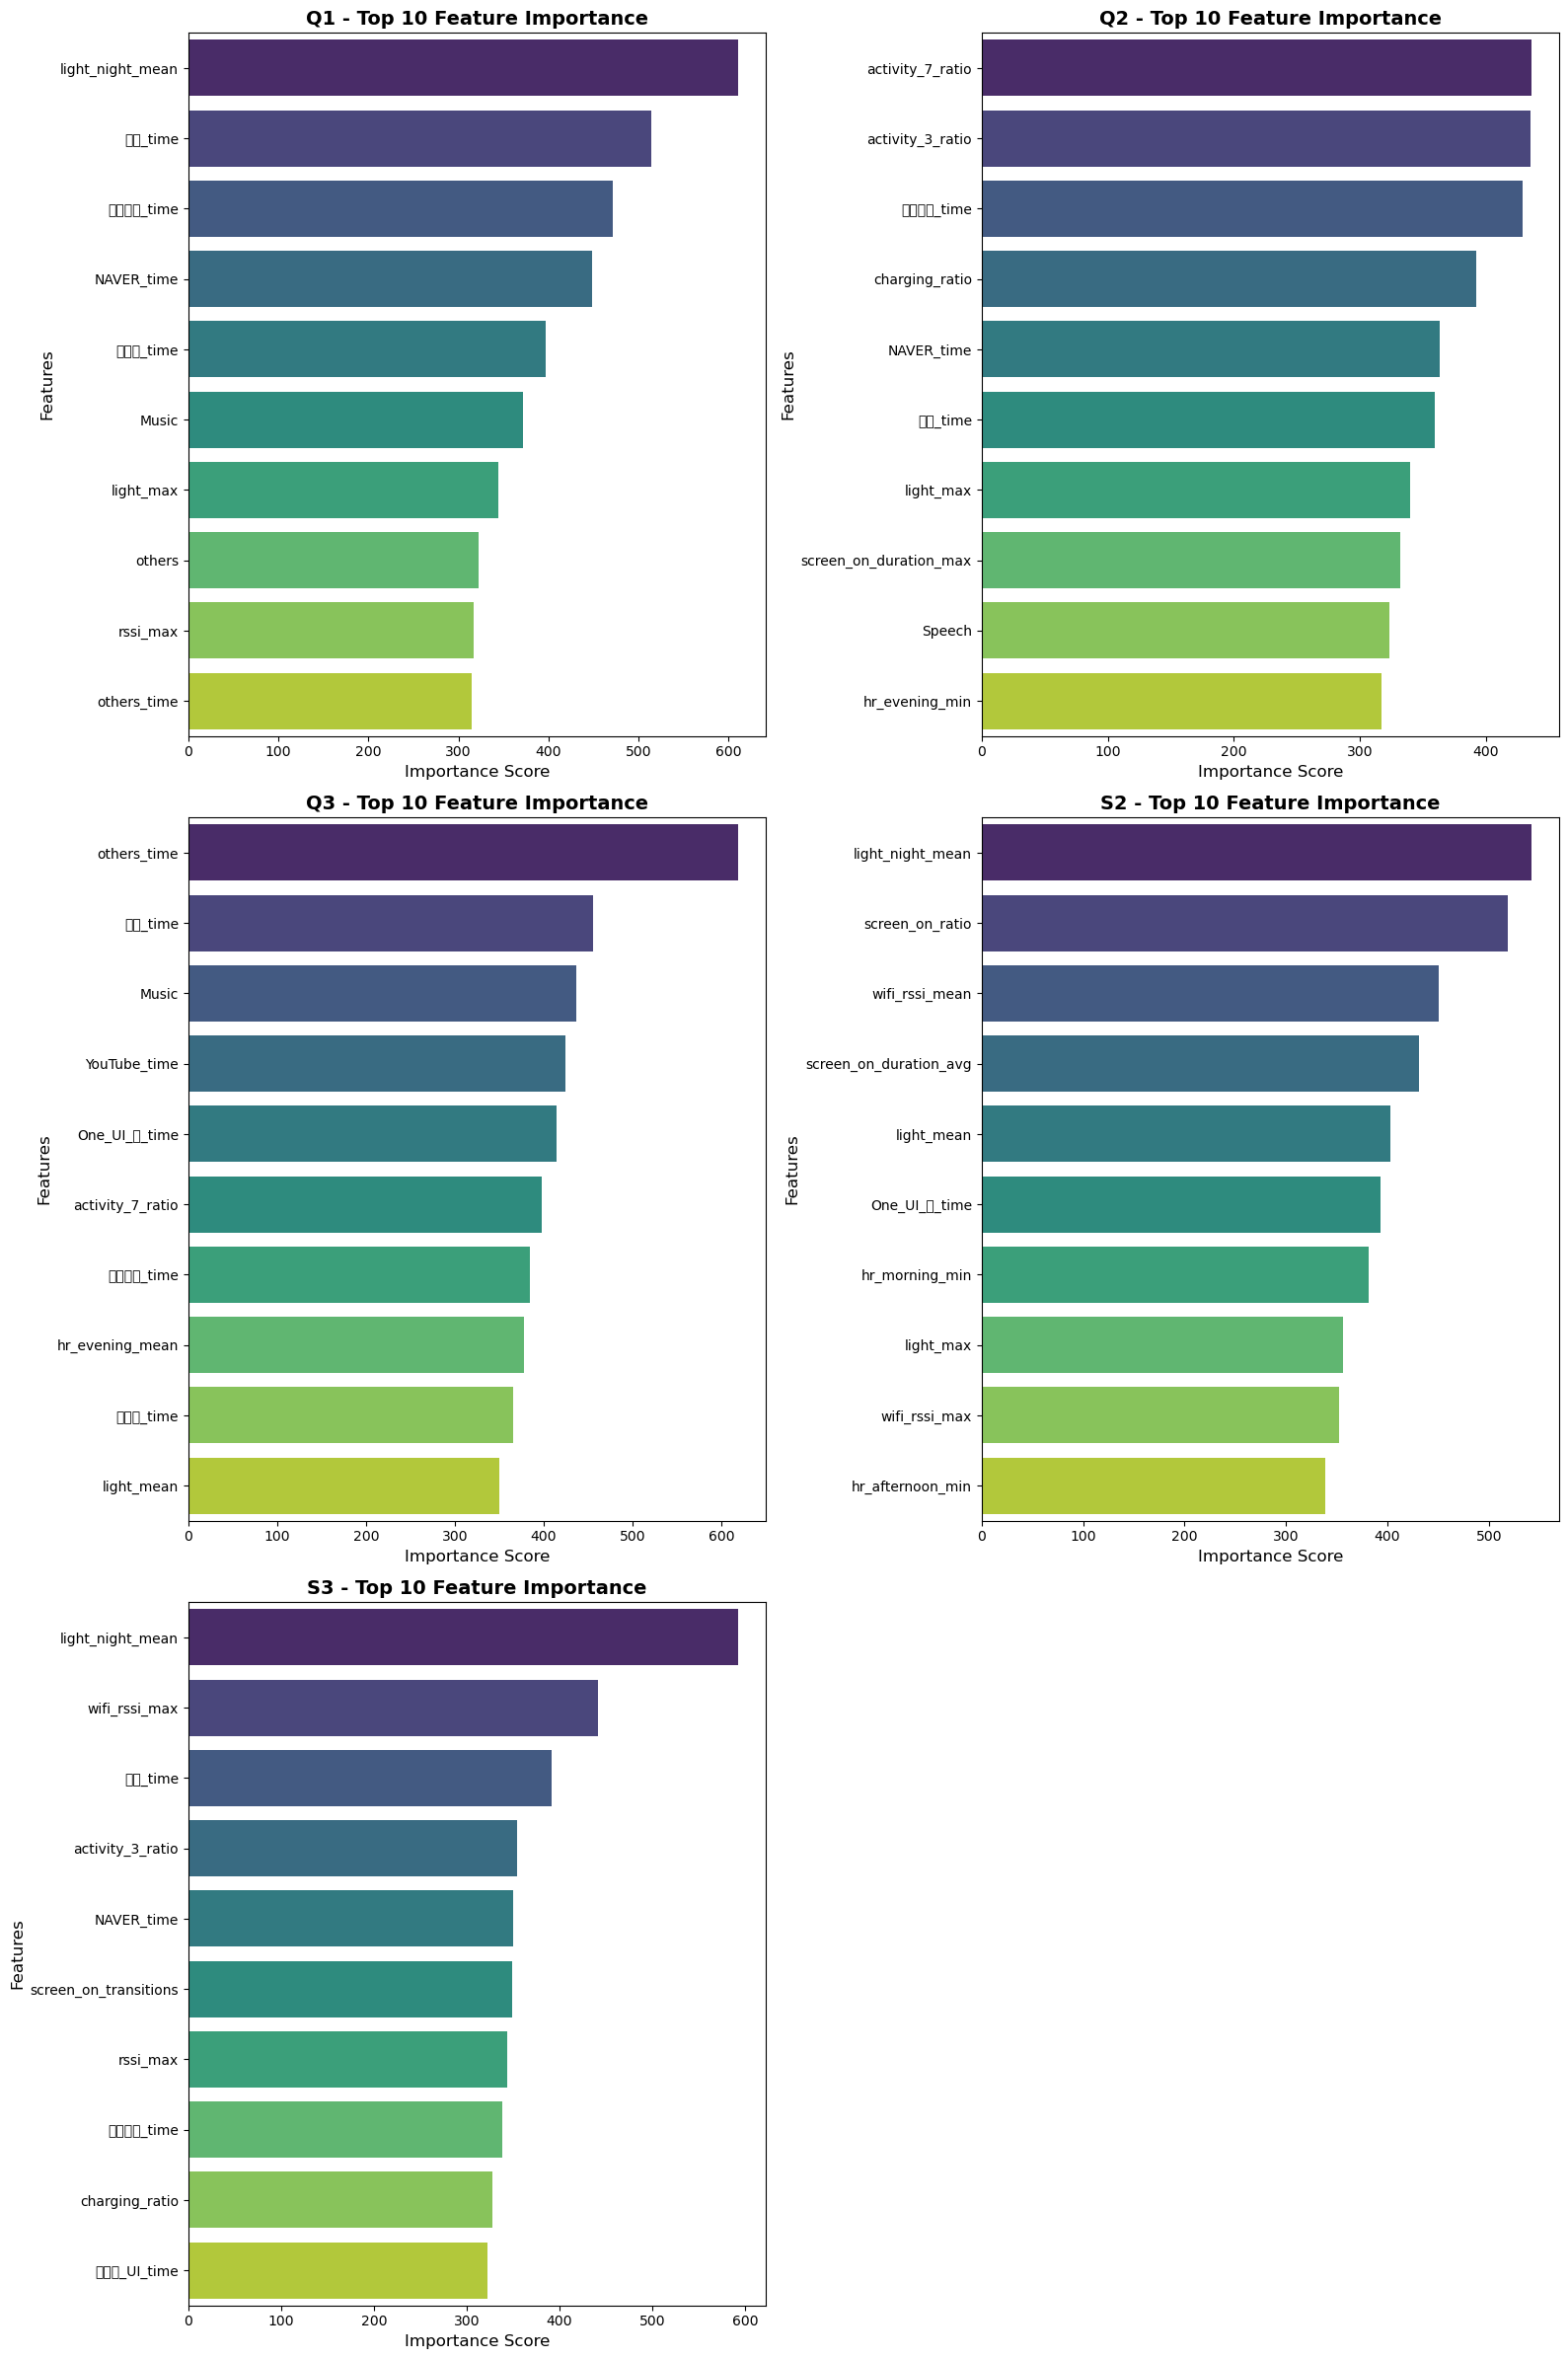

각 모델별 상위 10개 Feature Importance 저장 완료!

🔹 Q1 모델:
   - 상위 10개 피처 저장됨
   - 변수명: feature_importance_dict['Q1']
   - 최고 중요도: 611.0000 (light_night_mean)
   - 최저 중요도: 315.0000 (others_time)

🔹 Q2 모델:
   - 상위 10개 피처 저장됨
   - 변수명: feature_importance_dict['Q2']
   - 최고 중요도: 436.0000 (activity_7_ratio)
   - 최저 중요도: 317.0000 (hr_evening_min)

🔹 Q3 모델:
   - 상위 10개 피처 저장됨
   - 변수명: feature_importance_dict['Q3']
   - 최고 중요도: 619.0000 (others_time)
   - 최저 중요도: 350.0000 (light_mean)

🔹 S2 모델:
   - 상위 10개 피처 저장됨
   - 변수명: feature_importance_dict['S2']
   - 최고 중요도: 542.0000 (light_night_mean)
   - 최저 중요도: 339.0000 (hr_afternoon_min)

🔹 S3 모델:
   - 상위 10개 피처 저장됨
   - 변수명: feature_importance_dict['S3']
   - 최고 중요도: 593.0000 (light_night_mean)
   - 최저 중요도: 322.0000 (시스템_UI_time)

📌 사용 방법:
   - 특정 모델 결과 확인: feature_importance_dict['Q1']
   - CSV 저장: feature_importance_dict['Q1'].to_csv('Q1_feature_importance.csv')
   - 전체 모델 결과: feature_importance_dict.keys()


In [30]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# 각 모델별 상위 10개 피처 중요도를 저장할 딕셔너리
feature_importance_dict = {}

# subplot 수 계산
n_models = len(binary_models_selected)
n_cols = 2  # 한 줄에 두 개씩
n_rows = math.ceil(n_models / n_cols)

# subplot 생성 (10개 피처를 표시하기 위해 높이 증가)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8 * n_rows))
axes = axes.flatten()  # 2D -> 1D 배열로 변환

for idx, (col_name, model) in enumerate(binary_models_selected.items()):
    # 상위 10개 피처 중요도 추출
    importance_df = pd.DataFrame({
        'feature': X_selected.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)  # 상위 10개
    
    # 📌 각 모델별로 feature importance 저장
    feature_importance_dict[col_name] = importance_df.copy()
    
    # 시각화 (상위 10개)
    sns.barplot(
        x='importance', y='feature', 
        data=importance_df, 
        ax=axes[idx], 
        palette='viridis'
    )
    axes[idx].set_title(f'{col_name} - Top 10 Feature Importance', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Importance Score', fontsize=12)
    axes[idx].set_ylabel('Features', fontsize=12)
    
    # y축 레이블 크기 조정 (20개 피처명이 겹치지 않도록)
    axes[idx].tick_params(axis='y', labelsize=10)
    axes[idx].tick_params(axis='x', labelsize=10)

# 남은 빈 subplot 제거
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 📊 각 모델별 feature importance 결과 출력
print("="*60)
print("각 모델별 상위 10개 Feature Importance 저장 완료!")
print("="*60)

for model_name, df in feature_importance_dict.items():
    print(f"\n🔹 {model_name} 모델:")
    print(f"   - 상위 10개 피처 저장됨")
    print(f"   - 변수명: feature_importance_dict['{model_name}']")
    print(f"   - 최고 중요도: {df.iloc[0]['importance']:.4f} ({df.iloc[0]['feature']})")
    print(f"   - 최저 중요도: {df.iloc[-1]['importance']:.4f} ({df.iloc[-1]['feature']})")

print("\n" + "="*60)
print("📌 사용 방법:")
print("   - 특정 모델 결과 확인: feature_importance_dict['Q1']")
print("   - CSV 저장: feature_importance_dict['Q1'].to_csv('Q1_feature_importance.csv')")
print("   - 전체 모델 결과: feature_importance_dict.keys()")
print("="*60)

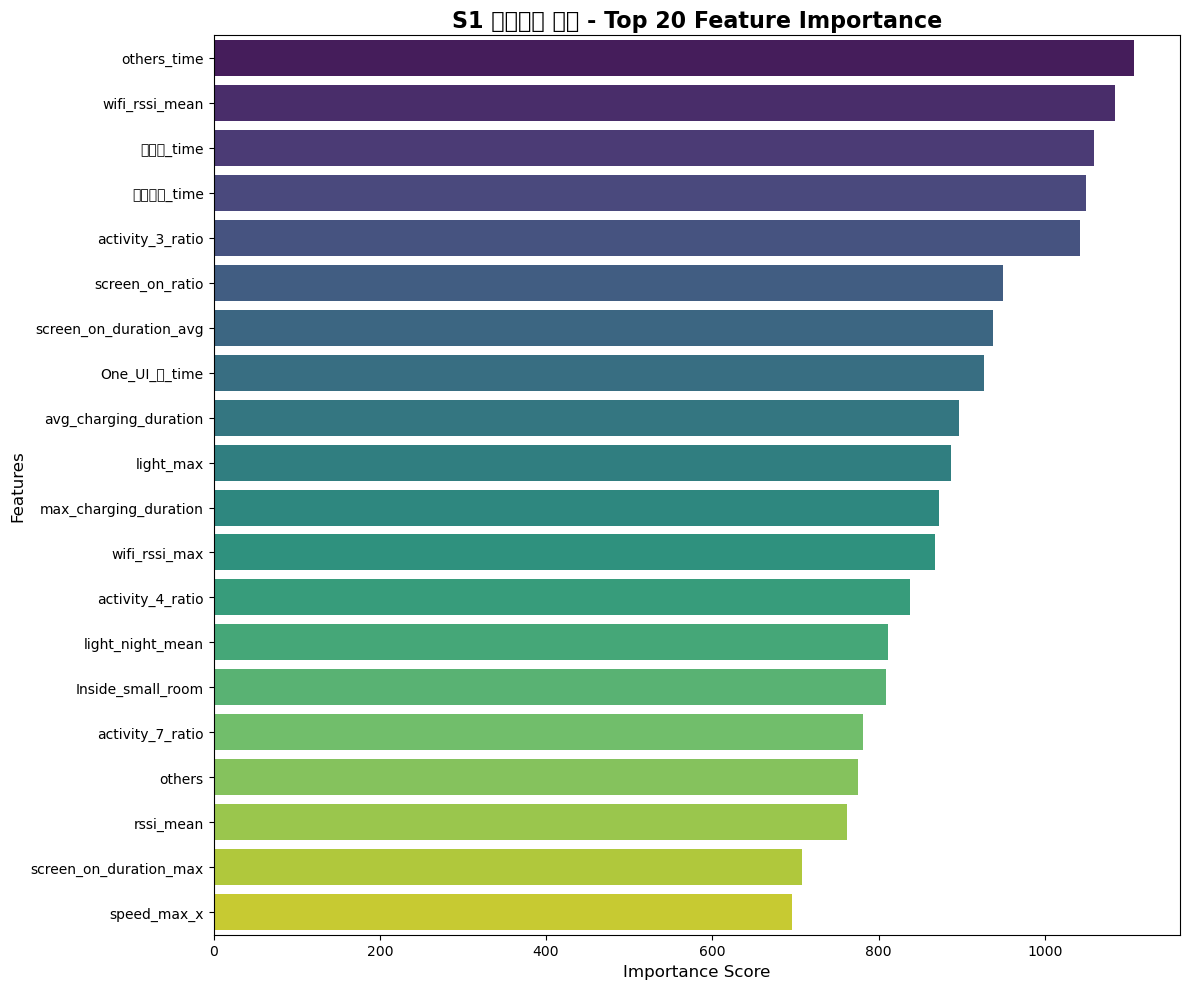

S1 다중분류 모델 Feature Importance 저장 완료!
🔹 S1 다중분류 모델:
   - 상위 20개 피처 저장됨
   - 변수명: feature_importance_dict['S1']
   - 최고 중요도: 1107.0000 (others_time)
   - 최저 중요도: 696.0000 (speed_max_x)

📌 사용 방법:
   - S1 다중분류 결과 확인: feature_importance_dict['S1']
   - CSV 저장: feature_importance_dict['S1'].to_csv('S1_multiclass_feature_importance.csv')
   - 전체 피처 확인: fi_multi (모든 피처)
   - 상위 20개만: fi_multi_20

💾 현재 저장된 모든 모델:
   - Q1
   - Q2
   - Q3
   - S2
   - S3
   - S1


In [31]:

# 중요도 추출
fi_multi = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': model_s1_selected.feature_importances_
}).sort_values('importance', ascending=False)

# top 20 features (상위 20개로 변경)
fi_multi_20 = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': model_s1_selected.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# 📌 feature_importance_dict에 S1 다중분류 모델 저장
feature_importance_dict['S1'] = fi_multi_20.copy()

# 시각화 (상위 20개로 변경)
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=fi_multi_20, palette='viridis')
plt.title('S1 다중분류 모델 - Top 20 Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# 📊 저장 완료 메시지
print("="*60)
print("S1 다중분류 모델 Feature Importance 저장 완료!")
print("="*60)
print(f"🔹 S1 다중분류 모델:")
print(f"   - 상위 20개 피처 저장됨")
print(f"   - 변수명: feature_importance_dict['S1']")
print(f"   - 최고 중요도: {fi_multi_20.iloc[0]['importance']:.4f} ({fi_multi_20.iloc[0]['feature']})")
print(f"   - 최저 중요도: {fi_multi_20.iloc[-1]['importance']:.4f} ({fi_multi_20.iloc[-1]['feature']})")

print("\n📌 사용 방법:")
print("   - S1 다중분류 결과 확인: feature_importance_dict['S1']")
print("   - CSV 저장: feature_importance_dict['S1'].to_csv('S1_multiclass_feature_importance.csv')")
print("   - 전체 피처 확인: fi_multi (모든 피처)")
print("   - 상위 20개만: fi_multi_20")

# 📋 현재 저장된 모든 모델 확인
print(f"\n💾 현재 저장된 모든 모델:")
for model_name in feature_importance_dict.keys():
    print(f"   - {model_name}")

print("="*60)

In [32]:

# import numpy as np
# import pandas as pd
# from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split

# print("\n===== 각 모델별 오토인코더를 사용한 고급 특성 추출 =====")

# # 각 모델별 결과를 저장할 딕셔너리들
# autoencoder_results = {}
# encoder_results = {}
# combined_features = {}

# # 모델 리스트
# model_names = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']

# for model_name in model_names:
#     print(f"\n🔹 {model_name} 모델 오토인코더 처리 시작...")
    
#     # 해당 모델의 상위 20개 중요 피처 선택
#     top_features = feature_importance_dict[model_name]['feature'].tolist()
    
#     # 중요 피처들로 데이터 필터링
#     X_model_selected = X_selected[top_features]
#     test_X_model_selected = test_X_selected[top_features]
    
#     print(f"   - 선택된 피처 수: 20개")
#     print(f"   - 최고 중요도 피처: {feature_importance_dict[model_name].iloc[0]['feature']}")
#     print(f"   - 인코딩 차원: 20개")
    
#     # 하이퍼파라미터 설정
#     encoding_dim = min(64, 20)  # 20개 피처이므로 20으로 설정
#     batch_size = 64
#     epochs = 100
#     input_dim = 20  # 각 모델별로 정확히 20개 피처
    
#     # 오토인코더 모델 구축 (원래 구조 유지)
#     input_layer = Input(shape=(input_dim,))
    
#     # 인코더 부분
#     encoded = Dense(128, activation='relu')(input_layer)
#     encoded = BatchNormalization()(encoded)
#     encoded = Dropout(0.3)(encoded)
#     encoded = Dense(64, activation='relu')(encoded)
#     encoded = BatchNormalization()(encoded)
#     encoded = Dense(encoding_dim, activation='relu')(encoded)
    
#     # 디코더 부분
#     decoded = Dense(64, activation='relu')(encoded)
#     decoded = BatchNormalization()(decoded)
#     decoded = Dropout(0.3)(decoded)
#     decoded = Dense(128, activation='relu')(decoded)
#     decoded = BatchNormalization()(decoded)
#     decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
#     # 전체 오토인코더 모델
#     autoencoder = Model(input_layer, decoded)
#     autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
#     # 인코더 부분만 추출 (특성 추출용)
#     encoder = Model(input_layer, encoded)
    
#     # 훈련/검증 세트 분리
#     X_train_auto, X_val_auto = train_test_split(X_model_selected, test_size=0.2, random_state=42)
    
#     # 조기 종료 설정
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         restore_best_weights=True
#     )
    
#     # 오토인코더 모델 학습
#     print(f"   - {model_name} 오토인코더 학습 중...")
#     history = autoencoder.fit(
#         X_train_auto, X_train_auto,
#         epochs=epochs,
#         batch_size=batch_size,
#         shuffle=True,
#         validation_data=(X_val_auto, X_val_auto),
#         callbacks=[early_stopping],
#         verbose=0  # 출력 최소화
#     )
    
#     # 인코딩된 특성 추출
#     encoded_features_train = encoder.predict(X_model_selected, verbose=0)
#     encoded_features_test = encoder.predict(test_X_model_selected, verbose=0)
    
#     # 원본 특성과 인코딩된 특성 결합
#     X_combined_model = np.hstack([X_model_selected.values, encoded_features_train])
#     test_X_combined_model = np.hstack([test_X_model_selected.values, encoded_features_test])
    
#     # 결과 저장
#     autoencoder_results[model_name] = autoencoder
#     encoder_results[model_name] = encoder
#     combined_features[model_name] = {
#         'train': X_combined_model,
#         'test': test_X_combined_model,
#         'original_features': top_features,
#         'original_shape': X_model_selected.shape,
#         'encoded_shape': encoded_features_train.shape,
#         'combined_shape': X_combined_model.shape
#     }
    
#     print(f"   ✅ {model_name} 완료!")
#     print(f"      - 원본 특성 수: 20개")
#     print(f"      - 인코딩된 특성 수: 20개")
#     print(f"      - 결합된 특성 수: 40개")
#     print(f"      - 최종 손실: {history.history['val_loss'][-1]:.4f}")



In [33]:
# print("\n" + "="*60)
# print("🎉 모든 모델별 오토인코더 처리 완료!")
# print("="*60)

# # 결과 요약
# print("\n📊 결과 요약:")
# for model_name in model_names:
#     result = combined_features[model_name]
#     print(f"🔹 {model_name}:")
#     print(f"   - 사용된 중요 피처: 20개")
#     print(f"   - 생성된 인코딩 피처: 20개") 
#     print(f"   - 최종 결합 피처: 40개")

# print("\n📌 사용 방법:")
# print("   - 특정 모델 결합 특성: combined_features['Q1']['train']")
# print("   - 테스트 데이터: combined_features['Q1']['test']")
# print("   - 오토인코더 모델: autoencoder_results['Q1']")
# print("   - 인코더 모델: encoder_results['Q1']")

# # 선택사항: 특정 모델의 오토인코더 성능 시각화
# import matplotlib.pyplot as plt

# def plot_autoencoder_loss(model_name):
#     """특정 모델의 오토인코더 학습 곡선 시각화"""
#     if model_name in autoencoder_results:
#         # 학습 이력이 저장되어 있다면 시각화
#         print(f"\n{model_name} 모델의 오토인코더 학습 곡선을 그리려면")
#         print(f"history = autoencoder_results['{model_name}'].fit() 에서 반환된 history를 사용하세요.")
#     else:
#         print(f"❌ {model_name} 모델을 찾을 수 없습니다.")

# print(f"\n💡 팁: 학습 곡선을 보려면 plot_autoencoder_loss('Q1') 함수를 사용하세요!")

In [34]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping 

# GridSearch를 위한 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # LightGBM 기본 파라미터 설정
# lgbm_params = {
#     'n_estimators': 1000,
#     'learning_rate': 0.03,
#     'random_state': 42,
#     'n_jobs': -1,
#     'verbosity': -1
# }

# 이진 분류 모델 성능 향상을 위한 그리드 서치 파라미터
binary_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [0, 0.01, 0.1],
}

# 다중 분류 모델 성능 향상을 위한 그리드 서치 파라미터
multi_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [0, 0.01, 0.1],
}

In [35]:
# print("\n===== 오토인코더를 사용한 고급 특성 추출 =====")

# # 하이퍼파라미터 설정
# encoding_dim = min(64, X_selected.shape[1])  # 인코딩 차원 (원본 특성 수보다 작게 설정)
# batch_size = 64
# epochs = 100

# # 입력 차원
# input_dim = X_selected.shape[1]

# # 오토인코더 모델 구축
# input_layer = Input(shape=(input_dim,))

# # 인코더 부분
# encoded = Dense(128, activation='relu')(input_layer)
# encoded = BatchNormalization()(encoded)
# encoded = Dropout(0.3)(encoded)
# encoded = Dense(64, activation='relu')(encoded)
# encoded = BatchNormalization()(encoded)
# encoded = Dense(encoding_dim, activation='relu')(encoded)

# # 디코더 부분
# decoded = Dense(64, activation='relu')(encoded)
# decoded = BatchNormalization()(decoded)
# decoded = Dropout(0.3)(decoded)
# decoded = Dense(128, activation='relu')(decoded)
# decoded = BatchNormalization()(decoded)
# decoded = Dense(input_dim, activation='sigmoid')(decoded)

# # 전체 오토인코더 모델
# autoencoder = Model(input_layer, decoded)
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# # 인코더 부분만 추출 (특성 추출용)
# encoder = Model(input_layer, encoded)


In [36]:
# # 훈련/검증 세트 분리
# X_train_auto, X_val_auto = train_test_split(X_selected, test_size=0.2, random_state=42)

# # 조기 종료 설정
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

# # 오토인코더 모델 학습
# print("오토인코더 학습 중...")
# autoencoder.fit(
#     X_train_auto, X_train_auto,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(X_val_auto, X_val_auto),
#     callbacks=[early_stopping],
#     verbose=1
# )

# # 인코딩된 특성 추출
# print("인코딩된 특성 추출 중...")
# encoded_features_train = encoder.predict(X_selected)
# encoded_features_test = encoder.predict(test_X_selected)

# # 원본 특성과 인코딩된 특성 결합
# X_combined = np.hstack([X_selected, encoded_features_train])
# test_X_combined = np.hstack([test_X_selected, encoded_features_test])

# print(f"원본 특성 수: {X_selected.shape[1]}")
# print(f"인코딩된 특성 수: {encoded_features_train.shape[1]}")
# print(f"결합된 특성 수: {X_combined.shape[1]}")


In [38]:
# ------------------ 각 모델별 결합된 특성으로 이진 분류 모델 학습 ------------------

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# 각 모델별 이진분류 결과를 저장할 딕셔너리
binary_models_individual = {}
binary_preds_individual = {}

# S1을 제외한 이진분류 모델들
binary_model_names = ['Q1', 'Q2', 'Q3', 'S2', 'S3']

# 각 모델이 해당 타겟만 예측 (Q1 모델→Q1 타겟, Q2 모델→Q2 타겟)
for model_name in binary_model_names:
    # 모델명과 타겟명 매칭 (Q1→Q1, Q2→Q2, Q3→Q3, S2→S2, S3→S3)
    target_col = model_name
    
        # 해당 모델의 상위 20개 중요 피처 선택
    top_features = feature_importance_dict[model_name]['feature'].tolist()
    
    # 중요 피처들로 데이터 필터링
    X_model_selected = X_selected[top_features]
    test_X_model_selected = test_X_selected[top_features]

    if target_col in targets_binary:
        y = train_df[target_col]
        
        print(f"\n{'='*60}")
        print(f"🎯 {model_name} 모델로 {target_col} 타겟 예측")
        print(f"{'='*60}")
        
        # # 해당 모델의 결합된 특성 사용
        # X_train_model = feature_importance_dict[model_name]['train']
        # X_test_model = feature_importance_dict[model_name]['test']
        
        # 해당 모델의 결합된 특성 사용
        X_train_model = X_model_selected
        X_test_model = test_X_model_selected

        print(f"   - 사용 특성 수: {X_train_model.shape[1]}개")
        print(f"   - 훈련 샘플 수: {X_train_model.shape[0]}개")
        print(f"   - 타겟: {target_col}")
        
        # 이진 분류용 모델 설정
        binary_model = LGBMClassifier(objective='binary', **lgbm_params)
        
        # 그리드 서치로 최적 파라미터 찾기
        grid_search = GridSearchCV(
            estimator=binary_model,
            param_grid=binary_param_grid,
            scoring='f1',  # 또는 'roc_auc', 'precision', 'recall' 등
            cv=cv,
            verbose=0,  # 출력 최소화
            n_jobs=-1
        )
        
        print(f"   - {model_name} 모델 최적화 중...")
        grid_search.fit(X_train_model, y)
        
        print(f"   ✅ 완료!")
        print(f"      - 최적 파라미터: {grid_search.best_params_}")
        print(f"      - 최고 F1 점수: {grid_search.best_score_:.4f}")
        
        # 최적 모델과 예측 결과 저장
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(X_test_model)
        
        # 결과 저장 (단순화된 구조)
        binary_models_individual[model_name] = best_model
        binary_preds_individual[model_name] = predictions
        
        print(f"      - 예측 완료: {len(predictions)}개 샘플")
    else:
        print(f"⚠️  {model_name} 모델에 해당하는 타겟 {target_col}을 찾을 수 없습니다.")

print(f"\n{'='*60}")
print("🎉 각 모델별 이진분류 학습 완료!")
print(f"{'='*60}")

# 📊 결과 요약
print(f"\n📊 학습 완료 요약:")
for model_name in binary_model_names:
    if model_name in binary_models_individual:
        print(f"   - {model_name} → {model_name} 타겟: ✅ 학습 완료")
    else:
        print(f"   - {model_name} → {model_name} 타겟: ❌ 학습 실패")

print(f"\n📌 결과 접근 방법:")
# print(f"   - Q1 모델: binary_models_individual['Q1']")
# print(f"   - Q1 예측: binary_preds_individual['Q1']")
# print(f"   - Q2 모델: binary_models_individual['Q2']")
# print(f"   - Q2 예측: binary_preds_individual['Q2']")
print(f"   - 학습된 모델들: {list(binary_models_individual.keys())}")

# 📈 성능 요약
def show_all_performance():
    """모든 모델 성능 요약"""
    print(f"\n📈 모든 모델 성능 요약:")
    print("-" * 50)
    
    for model_name in binary_model_names:
        if model_name in binary_models_individual:
            print(f"   {model_name} → {model_name}: 학습 완료 ✅")
        else:
            print(f"   {model_name} → {model_name}: 학습 실패 ❌")

# 사용 예시
show_all_performance()

# 📁 예측 결과 DataFrame 생성 (선택사항)
def create_all_predictions_df():
    """모든 모델의 예측 결과를 DataFrame으로 생성"""
    pred_dict = {}
    for model_name in binary_model_names:
        if model_name in binary_preds_individual:
            pred_dict[f'{model_name}_pred'] = binary_preds_individual[model_name]
    
    return pd.DataFrame(pred_dict)

print(f"\n📊 예측 결과 DataFrame 생성:")
print(f"   - 사용법: create_all_predictions_df()")
print(f"   - 결과: 각 모델별 예측값이 컬럼으로 저장된 DataFrame")
print(f"   - 컬럼: Q1_pred, Q2_pred, Q3_pred, S2_pred, S3_pred")


🎯 Q1 모델로 Q1 타겟 예측
   - 사용 특성 수: 10개
   - 훈련 샘플 수: 450개
   - 타겟: Q1
   - Q1 모델 최적화 중...
   ✅ 완료!
      - 최적 파라미터: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 50}
      - 최고 F1 점수: 0.6105
      - 예측 완료: 250개 샘플

🎯 Q2 모델로 Q2 타겟 예측
   - 사용 특성 수: 10개
   - 훈련 샘플 수: 450개
   - 타겟: Q2
   - Q2 모델 최적화 중...
   ✅ 완료!
      - 최적 파라미터: {'learning_rate': 0.03, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 1000, 'num_leaves': 50}
      - 최고 F1 점수: 0.6351
      - 예측 완료: 250개 샘플

🎯 Q3 모델로 Q3 타겟 예측
   - 사용 특성 수: 10개
   - 훈련 샘플 수: 450개
   - 타겟: Q3
   - Q3 모델 최적화 중...
   ✅ 완료!
      - 최적 파라미터: {'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 500, 'num_leaves': 50}
      - 최고 F1 점수: 0.7341
      - 예측 완료: 250개 샘플

🎯 S2 모델로 S2 타겟 예측
   - 사용 특성 수: 10개
   - 훈련 샘플 수: 450개
   - 타겟: S2
   - S2 모델 최적화 중...
   ✅ 완료!
      - 최적 파라미터: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500

In [39]:
# ------------------ S1 다중분류 모델 학습 (개별 특성 사용) ------------------

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# S1 다중분류 결과를 저장할 딕셔너리
multiclass_s1_individual = {}
multiclass_s1_preds_individual = {}

print(f"\n{'='*60}")
print(f"🎯 S1 모델로 S1 다중분류 타겟 예측")
print(f"{'='*60}")

# S1 타겟 데이터 준비
target_col = 'S1'
y_multiclass = train_df[target_col]

# 해당 모델의 상위 20개 중요 피처 선택
top_features = feature_importance_dict[target_col]['feature'].tolist()
    
# 중요 피처들로 데이터 필터링
X_model_selected = X_selected[top_features]
test_X_model_selected = test_X_selected[top_features]


# S1 모델의 결합된 특성 사용
X_train_s1 = X_model_selected
X_test_s1 = test_X_model_selected

print(f"   - 사용 특성 수: {X_train_s1.shape[1]}개")
print(f"   - 훈련 샘플 수: {X_train_s1.shape[0]}개")
print(f"   - 타겟: {target_col} (다중분류)")
print(f"   - 클래스 수: {len(y_multiclass.unique())}개")
print(f"   - 클래스 분포: {dict(y_multiclass.value_counts().sort_index())}")

# 다중분류용 모델 설정
multiclass_model = LGBMClassifier(
    objective='multiclass',
    metric='multi_logloss',
    **lgbm_params
)

# 다중분류용 파라미터 그리드 (필요시 별도 설정)
multiclass_param_grid = binary_param_grid.copy()  # 기본적으로 이진분류와 동일하게 사용

# 그리드 서치로 최적 파라미터 찾기
grid_search_multiclass = GridSearchCV(
    estimator=multiclass_model,
    param_grid=multiclass_param_grid,
    scoring='f1_macro',  # 다중분류에서는 f1_macro 또는 accuracy 사용
    cv=cv,
    verbose=0,  # 출력 최소화
    n_jobs=-1
)

print(f"   - S1 다중분류 모델 최적화 중...")
grid_search_multiclass.fit(X_train_s1, y_multiclass)

print(f"   ✅ 완료!")
print(f"      - 최적 파라미터: {grid_search_multiclass.best_params_}")
print(f"      - 최고 F1-Macro 점수: {grid_search_multiclass.best_score_:.4f}")

# 최적 모델과 예측 결과 저장
best_multiclass_model = grid_search_multiclass.best_estimator_
multiclass_predictions = best_multiclass_model.predict(X_test_s1)
multiclass_probabilities = best_multiclass_model.predict_proba(X_test_s1)

# 결과 저장
multiclass_s1_individual['model'] = best_multiclass_model
multiclass_s1_individual['predictions'] = multiclass_predictions
multiclass_s1_individual['probabilities'] = multiclass_probabilities
multiclass_s1_individual['classes'] = best_multiclass_model.classes_

print(f"      - 예측 완료: {len(multiclass_predictions)}개 샘플")
print(f"      - 예측된 클래스 분포: {dict(pd.Series(multiclass_predictions).value_counts().sort_index())}")

print(f"\n{'='*60}")
print("🎉 S1 다중분류 모델 학습 완료!")
print(f"{'='*60}")

# 📊 S1 다중분류 결과 요약
print(f"\n📊 S1 다중분류 학습 완료 요약:")
print(f"   - S1 → S1 다중분류 타겟: ✅ 학습 완료")

print(f"\n📌 S1 다중분류 결과 접근 방법:")
print(f"   - S1 모델: multiclass_s1_individual['model']")
print(f"   - S1 예측: multiclass_s1_individual['predictions']")
print(f"   - S1 확률: multiclass_s1_individual['probabilities']")
print(f"   - 클래스 정보: multiclass_s1_individual['classes']")

# 📈 S1 다중분류 성능 요약
def show_s1_multiclass_performance():
    """S1 다중분류 모델 성능 요약"""
    print(f"\n📈 S1 다중분류 모델 성능 요약:")
    print("-" * 50)
    print(f"   S1 → S1 (다중분류): 학습 완료 ✅")
    print(f"   최고 F1-Macro 점수: {grid_search_multiclass.best_score_:.4f}")
    print(f"   클래스 수: {len(multiclass_s1_individual['classes'])}개")
    print(f"   클래스: {list(multiclass_s1_individual['classes'])}")

# 사용 예시
show_s1_multiclass_performance()

# 📁 S1 다중분류 예측 결과 DataFrame 생성
def create_s1_multiclass_df():
    """S1 다중분류 예측 결과를 DataFrame으로 생성"""
    result_dict = {
        'S1_multiclass_pred': multiclass_s1_individual['predictions']
    }
    
    # 각 클래스별 확률도 추가
    probabilities = multiclass_s1_individual['probabilities']
    classes = multiclass_s1_individual['classes']
    
    for i, class_name in enumerate(classes):
        result_dict[f'S1_class_{class_name}_prob'] = probabilities[:, i]
    
    return pd.DataFrame(result_dict)

print(f"\n📊 S1 다중분류 예측 결과 DataFrame 생성:")
print(f"   - 사용법: create_s1_multiclass_df()")
print(f"   - 결과: S1 예측값과 각 클래스별 확률이 포함된 DataFrame")

# 📋 전체 모델 통합 요약
def show_all_models_summary():
    """이진분류 + 다중분류 모든 모델 요약"""
    print(f"\n📋 전체 모델 학습 완료 요약:")
    print("=" * 60)
    
    print(f"🔹 이진분류 모델들:")
    for model_name in binary_model_names:
        if model_name in binary_models_individual:
            print(f"   - {model_name} → {model_name}: ✅")
        else:
            print(f"   - {model_name} → {model_name}: ❌")
    
    print(f"\n🔹 다중분류 모델:")
    print(f"   - S1 → S1 (다중분류): ✅")
    
    print(f"\n📊 총 학습된 모델 수:")
    binary_count = len([m for m in binary_model_names if m in binary_models_individual])
    multiclass_count = 1 if 'model' in multiclass_s1_individual else 0
    total_count = binary_count + multiclass_count
    
    print(f"   - 이진분류: {binary_count}개")
    print(f"   - 다중분류: {multiclass_count}개")
    print(f"   - 총합: {total_count}개")

# 전체 요약 출력
show_all_models_summary()

# 📁 통합 예측 결과 생성
def create_all_predictions_combined():
    """이진분류 + 다중분류 모든 예측 결과를 DataFrame으로 생성"""
    # 이진분류 결과
    pred_dict = {}
    for model_name in binary_model_names:
        if model_name in binary_preds_individual:
            pred_dict[f'{model_name}_binary'] = binary_preds_individual[model_name]
    
    # 다중분류 결과 추가
    if 'predictions' in multiclass_s1_individual:
        pred_dict['S1_multiclass'] = multiclass_s1_individual['predictions']
    
    return pd.DataFrame(pred_dict)

print(f"\n🎯 통합 예측 결과 DataFrame:")
print(f"   - 사용법: create_all_predictions_combined()")
print(f"   - 포함: 모든 이진분류 + S1 다중분류 예측 결과")
print(f"=" * 60)


🎯 S1 모델로 S1 다중분류 타겟 예측
   - 사용 특성 수: 20개
   - 훈련 샘플 수: 450개
   - 타겟: S1 (다중분류)
   - 클래스 수: 3개
   - 클래스 분포: {0: 143, 1: 224, 2: 83}
   - S1 다중분류 모델 최적화 중...
   ✅ 완료!
      - 최적 파라미터: {'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 1000, 'num_leaves': 50}
      - 최고 F1-Macro 점수: 0.4535
      - 예측 완료: 250개 샘플
      - 예측된 클래스 분포: {0: 70, 1: 160, 2: 20}

🎉 S1 다중분류 모델 학습 완료!

📊 S1 다중분류 학습 완료 요약:
   - S1 → S1 다중분류 타겟: ✅ 학습 완료

📌 S1 다중분류 결과 접근 방법:
   - S1 모델: multiclass_s1_individual['model']
   - S1 예측: multiclass_s1_individual['predictions']
   - S1 확률: multiclass_s1_individual['probabilities']
   - 클래스 정보: multiclass_s1_individual['classes']

📈 S1 다중분류 모델 성능 요약:
--------------------------------------------------
   S1 → S1 (다중분류): 학습 완료 ✅
   최고 F1-Macro 점수: 0.4535
   클래스 수: 3개
   클래스: [0, 1, 2]

📊 S1 다중분류 예측 결과 DataFrame 생성:
   - 사용법: create_s1_multiclass_df()
   - 결과: S1 예측값과 각 클래스별 확률이 포함된 DataFrame

📋 전체 모델 학습 완료 요약:
🔹 이진분류 모델들:
   - Q1 → Q1: ✅
   - Q2 

In [40]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

In [41]:
# 🔄 개별 모델 예측 결과 사용
# S1 다중분류 예측 결과 사용
s1_predictions = multiclass_s1_individual['predictions']
assert len(submission_final) == len(s1_predictions), f"길이 불일치: submission={len(submission_final)}, S1 predictions={len(s1_predictions)}"

# 다중 분류 예측 붙이기 (개별 S1 모델 결과)
submission_final['S1'] = s1_predictions

# 이진 분류 결과 붙이기 (각 개별 모델 결과)
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    # 개별 모델의 예측 결과 사용
    individual_predictions = binary_preds_individual[col]
    
    # shape 체크
    assert len(submission_final) == len(individual_predictions), f"길이 불일치: submission={len(submission_final)}, {col} predictions={len(individual_predictions)}"
    
    submission_final[col] = individual_predictions.astype(int)  # 확률 아닌 class 예측



In [42]:
# 📊 예측 결과 요약 출력
print("📊 개별 모델 예측 결과 요약:")
print("=" * 40)

for col in ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']:
    value_counts = submission_final[col].value_counts().sort_index()
    total = len(submission_final)
    print(f"🔹 {col}:")
    for value, count in value_counts.items():
        percentage = (count / total) * 100
        print(f"   클래스 {value}: {count:,}개 ({percentage:.1f}%)")

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]



# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

# VSCode에서는 files.download()가 작동하지 않으므로 대체

print(f"✅ 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")

📊 개별 모델 예측 결과 요약:
🔹 Q1:
   클래스 0: 125개 (50.0%)
   클래스 1: 125개 (50.0%)
🔹 Q2:
   클래스 0: 95개 (38.0%)
   클래스 1: 155개 (62.0%)
🔹 Q3:
   클래스 0: 75개 (30.0%)
   클래스 1: 175개 (70.0%)
🔹 S1:
   클래스 0: 70개 (28.0%)
   클래스 1: 160개 (64.0%)
   클래스 2: 20개 (8.0%)
🔹 S2:
   클래스 0: 58개 (23.2%)
   클래스 1: 192개 (76.8%)
🔹 S3:
   클래스 0: 63개 (25.2%)
   클래스 1: 187개 (74.8%)
✅ 제출 파일이 저장되었습니다: c:\Users\KTL\Desktop\submission_final_mod4_1_2_0609_1052.csv
